In [49]:
import os
import random
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [50]:
def grayscale_conversion():
    folders = ["n02102318-cocker_spaniel", "n02105056-groenendael", "n02106382-Bouvier_des_Flandres",
               "n02107574-Greater_Swiss_Mountain_dog"]
    
    no_of_images = []
    for folder in folders:
        files = [f for f in os.listdir(f"../Cropped/{folder}") if os.path.isfile(os.path.join(f"../Cropped/{folder}", f))]
        no_of_images.append(len(files))
    
    collect = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"../Cropped/{folder}")
        collect[folder] = all_files
        
    
    grayscaled_images = {}
    for folder, images in collect.items():
        combine = []
        for img in images:
            path = f"../Cropped/{folder}/{img}"
            loaded_image = cv.imread(path)
            combine.append(cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY))
        grayscaled_images[folder] = combine
    
    return grayscaled_images 

In [51]:
def standardize_dataset():
    grayscaled_images = grayscale_conversion()
        
    standardized_images = {}
    for folder, images in grayscaled_images.items():
        combine = []
        for img in images:
            assert img is not None
            histogram, bins = np.histogram(img.flatten(), 256, [0,256])
            histogram = histogram / histogram.sum().ravel()
            combine.append(histogram)
        standardized_images[folder] = combine
    
    return standardized_images

In [52]:
def split_dataset():
    standardized_images = standardize_dataset()
    
    training_set = {}
    testing_set = {}
    for folder in standardized_images:
        perce_80 = int(len(standardized_images[folder]) * 0.8)
        training_set[folder] = random.sample(standardized_images[folder], perce_80)
    
    for folder, images in standardized_images.items():
        combine = []
        for img in images:
            if not np.all(np.equal(img, training_set[folder]), axis=1).any():
                combine.append(img)             
        testing_set[folder] = combine
    
    return training_set, testing_set

In [53]:
def train_test_split():
    training_set, testing_set = split_dataset()
    
    count = 0
    X_train, y_train, X_test, y_test = ([] for i in range(4))
    for training_folder, testing_folder in zip(training_set, testing_set):
        for training_image, testing_image in zip(training_set[training_folder], testing_set[testing_folder]):
            X_train.append(training_image)
            X_test.append(testing_image)
            y_train.append(count)
            y_test.append(count)
        count += 1
        
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test

In [57]:
def knn_classifier():
    X_train, y_train, X_test, y_test = train_test_split()
    kf = KFold(n_splits=5)
    skf = StratifiedKFold(n_splits=5)
    
    no_neighbors = [1, 3, 5, 7, 10, 20]
    
    for k in no_neighbors:
        knn = KNeighborsClassifier(k)
        
        scores = []
        for train_index, test_index in kf.split(X_train, y_train):
            X_tr, X_te = X_train[train_index], X_train[test_index]
            y_tr, y_te = y_train[train_index], y_train[test_index]
            
            knn.fit(X_tr, y_tr)
            scores.append(knn.score(X_te, y_te))
            
        result = np.mean(scores)
        print(f"result for k = {k}: {result:0.2f}")
    
    
    for k in no_neighbors:
        knn = KNeighborsClassifier(k)
        
        scores = []
        for train_index, test_index in skf.split(X_train, y_train):
            X_tr, X_te = X_train[train_index], X_train[test_index]
            y_tr, y_te = y_train[train_index], y_train[test_index]
            
            knn.fit(X_tr, y_tr)
            scores.append(knn.score(X_te, y_te))
            
        result = np.mean(scores)
        print(f"result for k = {k}: {result:0.2f}")
        
knn_classifier()

result for k = 1: 0.35
result for k = 1: 0.35
result for k = 3: 0.35
result for k = 3: 0.35
result for k = 5: 0.39
result for k = 5: 0.39
result for k = 7: 0.37
result for k = 7: 0.37
result for k = 10: 0.36
result for k = 10: 0.36
result for k = 20: 0.38
result for k = 20: 0.38


0.4005698005698005


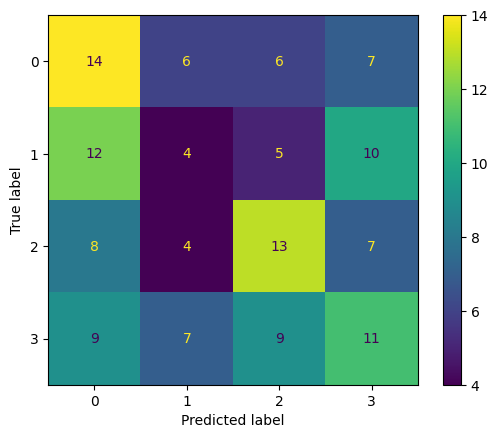

In [45]:
def naive_bayes_classifier():
    X_train, y_train, X_test, y_test = train_test_split()
    gnb = GaussianNB()
    skf = StratifiedKFold(n_splits=5)
    
    scores = []
    confu_matrix = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_te = X_train[train_index], X_train[test_index]
        y_tr, y_te = y_train[train_index], y_train[test_index]
        
        gnb.fit(X_tr, y_tr)
        y_pred = gnb.predict(X_te)
        
        confu_matrix.extend(y_pred)
        scores.append(gnb.score(X_te, y_te))
    
    result = np.mean(scores)
    print(result)
    
    cm = confusion_matrix(y_test, confu_matrix)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
naive_bayes_classifier()

C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.36381766381766384


C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


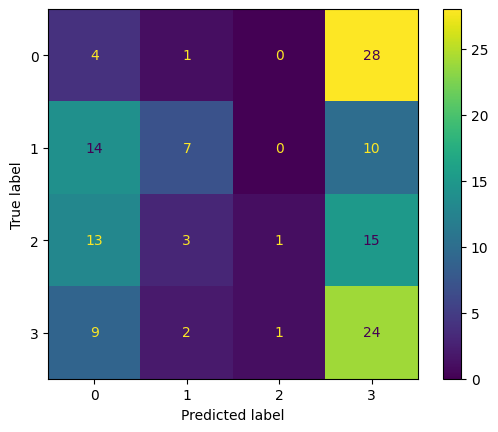

In [43]:
def neural_network_classifier():
    X_train, y_train, X_test, y_test = train_test_split()
    clf = MLPClassifier(hidden_layer_sizes=(10, 10, 10))
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    scores = []
    confu_matrix = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_te = X_train[train_index], X_train[test_index]
        y_tr, y_te = y_train[train_index], y_train[test_index]
    
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)
        
        confu_matrix.extend(y_pred)
        scores.append(clf.score(X_te, y_te))
        
    result = np.mean(scores)
    print(result)
    
    cm = confusion_matrix(y_test, confu_matrix)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
neural_network_classifier()

0.3481481481481481


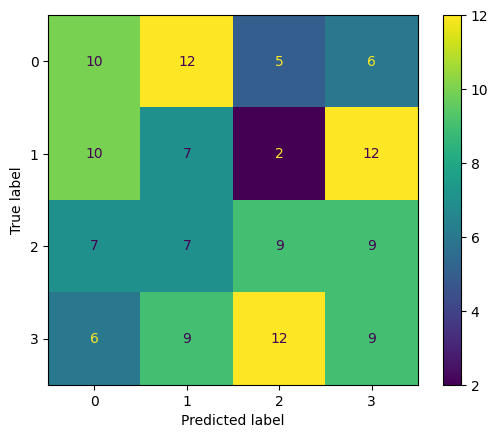

In [48]:
def ada_boost_classifier():
    X_train, y_train, X_test, y_test = train_test_split()
    ada = AdaBoostClassifier()
    skf = StratifiedKFold(n_splits=5)
    
    scores = []
    confu_matrix = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_te = X_train[train_index], X_train[test_index]
        y_tr, y_te = y_train[train_index], y_train[test_index]
        
        ada.fit(X_tr, y_tr)
        y_pred = ada.predict(X_te)
        
        scores.append(ada.score(X_te, y_te))
        confu_matrix.extend(y_pred)
    
    result = np.mean(scores)
    print(result)
    
    cm = confusion_matrix(y_test, confu_matrix)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
ada_boost_classifier()